## Plot results for all experiments
After running the other two experiment notebooks, this notebook will import the results and analyze results.

This experiment varies the following:

* Data Parallel method: Tensorflow MirroredStrategy versus PyTorch DataParallel
* Dataset size: MNIST digits repeated 1x, 4x, 8x = 60k, 240k, 480k training images
* Model size: Small with 402k trainable parameters, large with 2.6m trainable parameters. Both: adam optimizer, cross entropy loss
* Batch size: 128, 256, 512 images
* GPUs: I used: GCP n1-highmem-2 (2 vCPUs, 13 GB memory) with {1, 2, 4} NVIDIA Tesla K80 GPUs

And then it records:

* First epoch train time: incurs any startup costs
* Second epoch train time: representative of future epoch train times since training incurs same number of operations/epoch

Please note this is not a completely "apples-to-apples" comparison as torch DataParallel and tf MirroredStrategy have very different methods. PyTorch also includes a data parallel strategy which is expected to be more efficient called DistributedDataParalell which is worth investigating in future work.

### load and process data

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('data/tensorflow_results.txt', 'r') as f:
    df_tf = pd.DataFrame([json.loads(l) for l in f])
    df_tf['package'] = ['tensorflow']*len(df_tf)
    
with open('data/pytorch_results.txt', 'r') as f:
    df_pt = pd.DataFrame([json.loads(l) for l in f])
    df_pt['package'] = ['pytorch']*len(df_pt)
    
df = pd.concat([df_tf,df_pt])

LEN_MNIST_DATASET = 60000
df['first epoch img/s'] = (LEN_MNIST_DATASET*df['n_dataset_repeat'])/df['first epoch time']
df['second epoch img/s'] = (LEN_MNIST_DATASET*df['n_dataset_repeat'])/df['second epoch time']

df.head(5)

,batch_size,first epoch time,model_size,n_dataset_repeat,n_gpus,second epoch time,package,first epoch img/s,second epoch img/s
0,128,37.105868,small,1,1,3.737418,tensorflow,1616.994918,16053.863924
1,128,49.251541,large,1,1,16.978359,tensorflow,1218.235994,3533.910433
2,128,40.085931,small,1,2,4.637264,tensorflow,1496.784495,12938.663833
3,128,44.431990,large,1,2,9.726946,tensorflow,1350.378410,6168.431489
4,128,46.047007,small,1,4,5.921960,tensorflow,1303.016285,10131.780694


### Plots

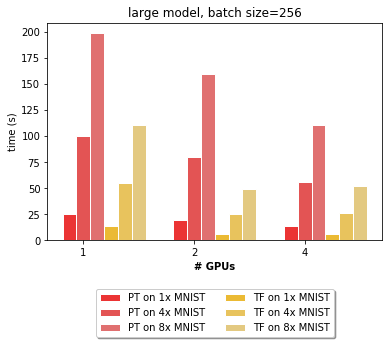

In [4]:
# set width of bar
barWidth = 0.125
 
# set height of bar
bars1 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch time'].values
bars2 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==4) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch time'].values
bars3 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch time'].values
bars4 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch time'].values
bars5 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==4) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch time'].values
bars6 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch time'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, bars1, color='#eb3434', width=barWidth, edgecolor='white', label='PT on 1x MNIST')
plt.bar(r2, bars2, color='#e35454', width=barWidth, edgecolor='white', label='PT on 4x MNIST')
plt.bar(r3, bars3, color='#e07070', width=barWidth, edgecolor='white', label='PT on 8x MNIST')
plt.bar(r4, bars4, color='#ebba34', width=barWidth, edgecolor='white', label='TF on 1x MNIST')
plt.bar(r5, bars5, color='#e8c35d', width=barWidth, edgecolor='white', label='TF on 4x MNIST')
plt.bar(r6, bars6, color='#e3c981', width=barWidth, edgecolor='white', label='TF on 8x MNIST')
 
# Add xticks on the middle of the group bars
plt.title('large model, batch size=256')
plt.xlabel('# GPUs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '4'])
plt.ylabel('time (s)')

# Create legend & Show graphic
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fancybox=True, shadow=True)
plt.show()


As expected, the total time to train a model decreases with increased GPUs. Tensorflow MirroredStrategy is faster than PyTorch DataParallel. Scaleup is roughly linear for increased data size.

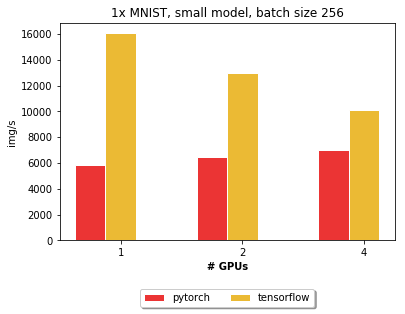

In [5]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==1) & (df['model_size']=='small') & (df['batch_size']==128)]['second epoch img/s'].values
bars2 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==1) & (df['model_size']=='small') & (df['batch_size']==128)]['second epoch img/s'].values

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#eb3434', width=barWidth, edgecolor='white', label='pytorch')
plt.bar(r2, bars2, color='#ebba34', width=barWidth, edgecolor='white', label='tensorflow')
 
# Add xticks on the middle of the group bars
plt.title('1x MNIST, small model, batch size 256')
plt.xlabel('# GPUs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '4'])
plt.ylabel('img/s')

# Create legend & Show graphic
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fancybox=True, shadow=True)
plt.show()


Note that when you use the small model, the results show that the processing speed (img/s) decreases as you increase the number of GPUs. When using a distributed learning method, there is a balance between computation and communication cost. At such a small model, the increased computation speed from additional processors is likely offset from additional communication cost.

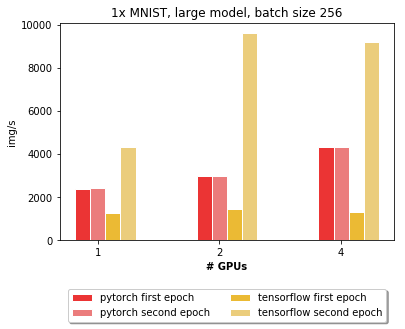

In [6]:
# set width of bar
barWidth = 0.125
 
# set height of bar
bars1 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['first epoch img/s'].values
bars2 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars3 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['first epoch img/s'].values
bars4 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='#eb3434', width=barWidth, edgecolor='white', label='pytorch first epoch')
plt.bar(r2, bars2, color='#eb7c7c', width=barWidth, edgecolor='white', label='pytorch second epoch')
plt.bar(r3, bars3, color='#ebba34', width=barWidth, edgecolor='white', label='tensorflow first epoch')
plt.bar(r4, bars4, color='#ebcd7c', width=barWidth, edgecolor='white', label='tensorflow second epoch')
 
# Add xticks on the middle of the group bars
plt.title('1x MNIST, large model, batch size 256')
plt.xlabel('# GPUs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '4'])
plt.ylabel('img/s')

# Create legend & Show graphic
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fancybox=True, shadow=True)
plt.show()


Note that PyTorch has a similar processing speed for first and second epoch while TensorFlow has a very slow first epoch and fast second epoch. This is likely due to the data sharding and other additional setup TensorFlow performs during the first epoch as opposed to PyTorch which distributes data batches over nodes at each iteration.

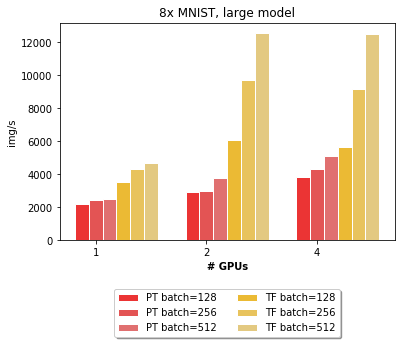

In [7]:
# set width of bar
barWidth = 0.125
 
# set height of bar
bars1 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==128)]['second epoch img/s'].values
bars2 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars3 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==512)]['second epoch img/s'].values
bars4 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==128)]['second epoch img/s'].values
bars5 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars6 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==512)]['second epoch img/s'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, bars1, color='#eb3434', width=barWidth, edgecolor='white', label='PT batch=128')
plt.bar(r2, bars2, color='#e35454', width=barWidth, edgecolor='white', label='PT batch=256')
plt.bar(r3, bars3, color='#e07070', width=barWidth, edgecolor='white', label='PT batch=512')
plt.bar(r4, bars4, color='#ebba34', width=barWidth, edgecolor='white', label='TF batch=128')
plt.bar(r5, bars5, color='#e8c35d', width=barWidth, edgecolor='white', label='TF batch=256')
plt.bar(r6, bars6, color='#e3c981', width=barWidth, edgecolor='white', label='TF batch=512')
 
# Add xticks on the middle of the group bars
plt.title('8x MNIST, large model')
plt.xlabel('# GPUs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '4'])
plt.ylabel('img/s')

# Create legend & Show graphic
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fancybox=True, shadow=True)
plt.show()


For a given system, as you increase batch size the processing speed increases. This confirms existing knowledge that systems are optimized when GPUs take advantage of as much memory available as possible. We also see for the large model that the processing speed performance remains relatively constant after 2 nodes.

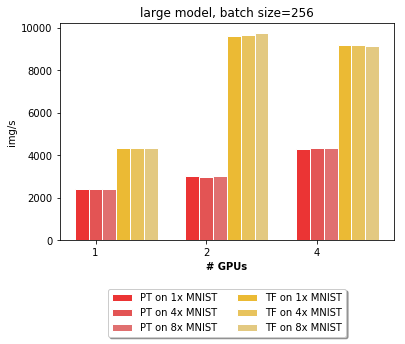

In [8]:
# set width of bar
barWidth = 0.125
 
# set height of bar
bars1 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars2 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==4) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars3 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars4 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==1) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars5 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==4) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars6 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, bars1, color='#eb3434', width=barWidth, edgecolor='white', label='PT on 1x MNIST')
plt.bar(r2, bars2, color='#e35454', width=barWidth, edgecolor='white', label='PT on 4x MNIST')
plt.bar(r3, bars3, color='#e07070', width=barWidth, edgecolor='white', label='PT on 8x MNIST')
plt.bar(r4, bars4, color='#ebba34', width=barWidth, edgecolor='white', label='TF on 1x MNIST')
plt.bar(r5, bars5, color='#e8c35d', width=barWidth, edgecolor='white', label='TF on 4x MNIST')
plt.bar(r6, bars6, color='#e3c981', width=barWidth, edgecolor='white', label='TF on 8x MNIST')
 
# Add xticks on the middle of the group bars
plt.title('large model, batch size=256')
plt.xlabel('# GPUs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '4'])
plt.ylabel('img/s')

# Create legend & Show graphic
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fancybox=True, shadow=True)
plt.show()


Processing speed shows little variation when varying the total dataset size. 

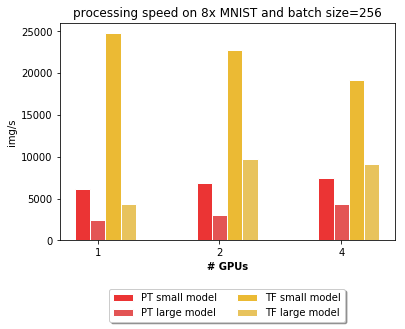

In [9]:
# set width of bar
barWidth = 0.125
 
# set height of bar
bars1 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==8) & (df['model_size']=='small') & (df['batch_size']==256)]['second epoch img/s'].values
bars2 = df[(df['package']=='pytorch') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
bars3 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==8) & (df['model_size']=='small') & (df['batch_size']==256)]['second epoch img/s'].values
bars4 = df[(df['package']=='tensorflow') & (df['n_dataset_repeat']==8) & (df['model_size']=='large') & (df['batch_size']==256)]['second epoch img/s'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='#eb3434', width=barWidth, edgecolor='white', label='PT small model')
plt.bar(r2, bars2, color='#e35454', width=barWidth, edgecolor='white', label='PT large model')
plt.bar(r3, bars3, color='#ebba34', width=barWidth, edgecolor='white', label='TF small model')
plt.bar(r4, bars4, color='#e8c35d', width=barWidth, edgecolor='white', label='TF large model')
 
# Add xticks on the middle of the group bars
plt.title('processing speed on 8x MNIST and batch size=256')
plt.xlabel('# GPUs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '4'])
plt.ylabel('img/s')

# Create legend & Show graphic
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fancybox=True, shadow=True)
plt.show()


Processing speed varies greatly based on model size. While the small model always has a faster processing speed, due to requiring fewer operations for forward and backward passes, we see that as you add additional GPUs, the processing speed on TensorFlow decreases. While this may seem unintuitive, this could be due to the tradeoff between computation and communication costs. It may be the case that as you add additional parameters to a distributed deep learning model, the computation speed decreases faster than the communication cost increases. For this reason, distributed deep learning becomes increasing advantageous with larger models.